In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
!wget --quiet -O escapecalculator.py https://raw.githubusercontent.com/jbloomlab/SARS2-RBD-escape-calc/main/escapecalculator.py

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated

In [4]:
mutated = get_rbd_mutated('../out/time-filtered-lineages/')

In [5]:
df = []
for name, idir in zip(['all-notime', 1_000, 10_000,
                       100_000, 1_000_000],
                      ['../out/'] +
                      ['../out/subsets-notime/'] * 4):
    df.append(read_mi(f'{idir}{name}/mi_annotated.tsv.gz', name, date=False))
df = pd.concat(df)

In [6]:
for name in df['name'].unique():
    tmp = df[df['name'] == name]
    print(name, ml_metrics(tmp, mutated))

all-notime (0.5384615384615384, 0.5384615384615384, 0.6363636363636364, 0.5555555555555556, 0.5334986442129299, 0.6785714285714286)
1000 (0.14246575342465753, 0.13930348258706468, 0.2564102564102564, 0.2285714285714286, 0.197203136787174, 0.6230646350454657)
10000 (0.3181818181818182, 0.4666666666666667, 0.7000000000000001, 0.75, 0.6612708719851577, 0.9285714285714285)
100000 (0.5185185185185185, 0.56, 0.6666666666666666, 0.6250000000000001, 0.5686662543805401, 0.7582417582417582)
1000000 (0.5185185185185185, 0.5384615384615384, 0.6363636363636364, 0.5555555555555556, 0.5280041387184244, 0.6923076923076923)


In [7]:
df.groupby('name')['pos_source'].count()

name
1000          67506
10000          3004
100000          716
1000000         488
all-notime      474
Name: pos_source, dtype: int64

In [8]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

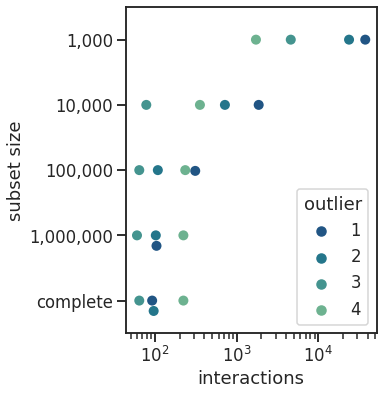

In [9]:
plt.figure(figsize=(4.5, 6))

sns.swarmplot(data=count,
              x='pos_source',
              y='name',
              hue='outlier',
              size=10,
              palette=sns.color_palette('crest_r', 4))

plt.yticks(range(5),
           ['1,000',
            '10,000',
            '100,000',
            '1,000,000',
            'complete'])

plt.legend(facecolor='w',
           title='outlier')

plt.xlabel('interactions')
plt.ylabel('subset size')

plt.xscale('log')

plt.savefig('subsets_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

1000 [1.08384498e+01 2.04740129e-17]
10000 [2.79206897e+01 2.52385067e-08]
100000 [6.44774536e+01 2.14984989e-10]
1000000 [6.44774536e+01 2.14984989e-10]


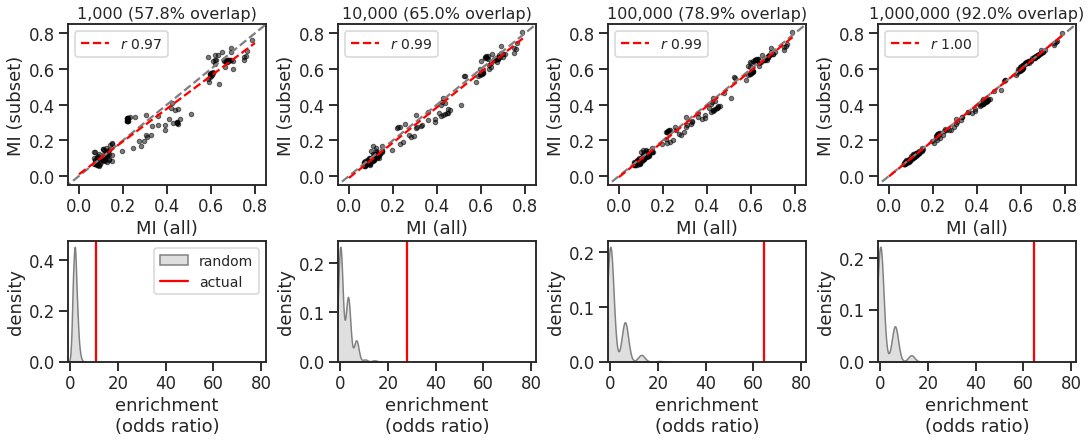

In [10]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s, mutated)
    
    sns.kdeplot(o[(o['type'] != 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'],
                bw_adjust=1.5,
                color='grey', label='random',
                fill=True,
                ax=ax)
    
    ax.axvline(o[(o['type'] == 'original') &
                 (o['randomization'] == 'any_positions')]['odds-ratio'].values,
            color='r',
            label='actual')

    print(subset,
          o[(o['type'] == 'original') &
            (o['randomization'] == 'any_positions')][['odds-ratio', 'p-value']].values[0])
    
    ax.set_xlim(-1, 82)
    ax.set_xticks([0, 20, 40, 60, 80])
    
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    # ax.set_xscale('log')

plt.savefig('subsets_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [11]:
df = df[df['outlier'] > 2].copy()

1000 [1.20361386e+02 3.06176094e-13]
10000 [1.19773399e+02 9.94189446e-12]
100000 [1.19773399e+02 9.94189446e-12]
1000000 [1.04797414e+02 1.85061124e-11]


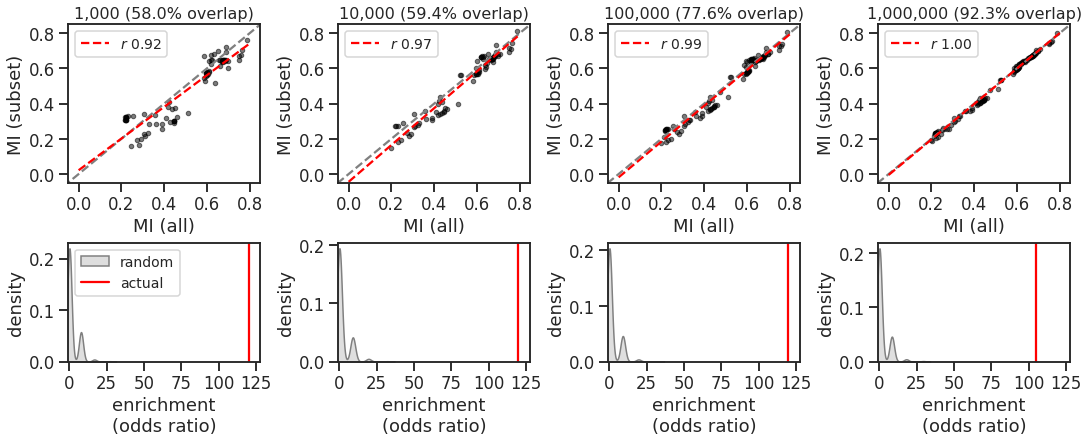

In [12]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s, mutated)
    
    sns.kdeplot(o[(o['type'] != 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'],
                bw_adjust=1.5,
                color='grey', label='random',
                fill=True,
                ax=ax)
    
    ax.axvline(o[(o['type'] == 'original') &
                 (o['randomization'] == 'any_positions')]['odds-ratio'].values,
            color='r',
            label='actual')

    print(subset,
          o[(o['type'] == 'original') &
            (o['randomization'] == 'any_positions')][['odds-ratio', 'p-value']].values[0])
    
    ax.set_xlim(-1, 128)
    ax.set_xticks([0, 25, 50, 75, 100, 125])
    
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    # ax.set_xscale('log')

plt.savefig('subsets_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);